# VARIATIONAL AUTOENCODER EXAMPLE (TENSORFLOW)
In this example we are going to use the MNIST dataset downloaded directly from tensorflow.examples.
First, we specify the different variables:
batch_size: number of instances used in the minibatch gradient descent approximation
X_in: Defining a placeholder for saving the images used in the training examples. The shape is the shape of the tensor
to be fed. None means that it will be the size of the batch. 
Y: This placeholder will hold the images reconstructed by the decoder part of the autoencoder
Y_flat: Y reshaped in order to be used when computing losses
keep_prob: This is used as a placeholder when using the dropout regularization technique
reshaped_dim: dimension of the decoder when sarting the transpose convolutional2D layers after the dense layers
architecture
inputs_decoder: The dimension of the inputs in the decoder phase
The leaky_relu is defined since tensorflow does not have a predefined one (since 1.4.0 release tf.nn.leaky_relu can be used)

The encoder if the first part of the architecture. In this phase, the aim is to find a lower dimensional representation of the images until obtaining the latent variables Z. Firstly, the images are reshaped according to the tensor dimensions:
[batch_size, height, width, channels]. -1 in batch_size means using the batch size defined when splitting the dataset
into batches. RGB for example has 3 channels whereas white and black images have 1 as channels.
The encoder has basically convolutional layers since we are treating with images. However, other types of architectures could be employed instead. 
The mean and standard deviation necessary for the reparametrization trick will be computed using two dense layers which
will be optimized for computing them via the gradients.
The decoder can sample from Q(Z|X) distribution in order to obtain the images back to their real form. Nonetheless, since sampling is stochastic we cannot use backpropagation! To solve this we can apply: z = mean + deviation * epsilon (* meaning elementwise or Hadamard multiplication). This way, all the randomness is saved in the epsilon variables and now
we can use gradients in order to optimize the theta and phi parameters. This is called the reparametrization trick.



# Importing packages and modules

In [1]:
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from tensorflow.examples.tutorials.mnist import input_data
from functools import wraps
import os, sys, time
%matplotlib inline 

# Decorators

This section include some interesting decorators that will be used in the autoencoder architecture.
Basically decorators are methods that modify the functionality of the function they decorate.

In [2]:
class Decorators(object):

    @staticmethod
    def tensorboad_graph(path=os.getcwd()):
        
        """
        This decorator allows to create the graph in tensorboard.
        run this command on the terminal in the directory "path": python -m tensorboard.main --logdir=.
        and then enter the following URL: http://localhost:6006/
        
        """
        def mydecorator(func):
            @wraps(func)
            def mywrapper(self, *args, **kwargs):
                func(self, *args, **kwargs)
                with tf.Session() as sess:
                    writer = tf.summary.FileWriter(os.path.join(path, "graphs"), sess.graph)
                    msg = \
                    """
                    run this command on the terminal in the directory "path": python -m tensorboard.main --logdir=.
                    and then enter the following URL: http://localhost:6006/
                    """
                    print("INSTRUCTIONS FOR TENSFORBOARD: \n {}".format(msg))
            return mywrapper
        return mydecorator
    
    @staticmethod
    def pca_latent(n_components=2, plot=True):
        
        """
        This decorator will be useful in order to create PCA
        representation of the latent variables and to plot it
        
        """
        def mydecorator(func):
            @wraps(func)
            def mywrapper(self, *args, **kwargs):
                func(self, *args, **kwargs)
                #Implement PCA of latent variables and plotting
            return mywrapper
        return mydecorator
    
    @staticmethod
    def timing(func):
        
        """
        This decorator allows to know how much time is the execution time of the
        decoratedd function/method in seconds
        
        """
        
        @wraps(func)
        def mywrapper(self, *args, **kwargs):
            start = time.time()
            return_variable = func(self, *args, **kwargs)
            end = time.time()
            print("Execution time of method {}: {} seconds".format(func.__name__, round(end-start, 3)))
            return return_variable
        return mywrapper
            
            
    
    
                

In [3]:
class PrepareData(object):

    def __init__(self, batch_size, latent_variables, dec_in_channels):
        
        self._mnist =  input_data.read_data_sets("MNIST", one_hot=False)
        self._X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name="X")
        self._Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name="Y")
        self._Y_flat = tf.reshape(self._Y, shape=[-1, 28 * 28])
        self._keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name="keep_prob") #Used for dropout layers
        self._number_of_latent_variables = latent_variables
        self._batch_size = batch_size
        self._dec_in_channels = dec_in_channels
        self._reshaped_dim = [-1, 7, 7, self._dec_in_channels]
        self._inputs_decoder = 49
        
    def __str__(self):
        
        return "variables: \n latent variables: {} \n batch size: {}".format(self._number_of_latent_variables, 
                                                                             self.batch_size)
    
class AutoencoderArchitecture(PrepareData):
    
    def __init__(self, batch_size, latent_variables, dec_in_channels):
        super(AutoencoderArchitecture, self).__init__(batch_size, latent_variables, dec_in_channels)
        
    def leaky_relu(self, x, alpha=0.3):
        return tf.maximum(x, tf.multiply(x, alpha))

    def _encoder(self):
        with tf.variable_scope("encoder", reuse=None):
            X_reshaped = tf.reshape(self._X_in, shape=[-1, 28, 28, 1]) #reshape where -1 means the batch_size, 
                                                                #28 the height, 28 the width and 1 the number of channels!
            X = tf.layers.conv2d(X_reshaped, filters=64, kernel_size=4, strides=2, padding="same", activation=self.leaky_relu)
            X = tf.nn.dropout(X, self._keep_prob)
            X = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding="same", activation=self.leaky_relu)

            X = tf.nn.dropout(X, self._keep_prob)
            X = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=1, 
                                 padding="same", activation=self.leaky_relu)
            X = tf.nn.dropout(X, self._keep_prob)
            X = tf.contrib.layers.flatten(X) 
            mean = tf.layers.dense(X, units=self._number_of_latent_variables)
            sd = 0.5 * tf.layers.dense(X, units=self._number_of_latent_variables)
            epsilon = tf.random_normal([tf.shape(X)[0], self._number_of_latent_variables])
            z = mean + tf.multiply(epsilon, tf.exp(sd)) #tf.multiply is elementwise or Hadamard multiplication!

            return z, mean, sd

    def _decoder(self, sampled_z):

        with tf.variable_scope("decoder", reuse=None):
            X = tf.layers.dense(sampled_z, units=self._inputs_decoder, activation=self.leaky_relu)
            X = tf.layers.dense(X, units=self._inputs_decoder, activation=self.leaky_relu)
            X = tf.reshape(X, self._reshaped_dim)
            X = tf.layers.conv2d_transpose(X, filters=64, kernel_size=4, strides=2, 
                                 padding="same", activation=tf.nn.relu)
            X = tf.nn.dropout(X, self._keep_prob)
            X = tf.layers.conv2d_transpose(X, filters=64, kernel_size=4, strides=1, 
                                 padding="same", activation=tf.nn.relu)
            X = tf.nn.dropout(X, self._keep_prob)
            X = tf.layers.conv2d_transpose(X, filters=64, kernel_size=4, strides=1, 
                                 padding="same", activation=tf.nn.relu)
            X_flatten = tf.contrib.layers.flatten(X)
            X_dense = tf.layers.dense(X_flatten, units=28*28, activation=tf.nn.sigmoid)
            img = tf.reshape(X_dense, shape=[-1, 28, 28])

            return img


class AutoencoderTrainer(AutoencoderArchitecture):
    
    def __init__(self, batch_size=64, latent_variables=20, dec_in_channels=1, iterations=100):
        super(AutoencoderTrainer, self).__init__(batch_size, latent_variables, dec_in_channels)

        self._sampled, self._mean, self._standard = self._encoder()
        self.__iterations = iterations
        
    @property
    def iterations(self):
        return self.__iterations
    
    @Decorators.timing
    def train(self):

        dec = self._decoder(self._sampled)
        unreshaped = tf.reshape(dec, [-1, 28 * 28])
        img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, self._Y_flat), 1) #Log-likelihood 
        latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * self._standard - tf.square(self._mean) - tf.exp(2.0 * self._standard), 1) #Kullback-Leibler divergence
        
        loss = tf.reduce_mean(img_loss + latent_loss)
        optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
        
        sess = tf.Session()
        sess.run(tf.global_variables_initializer()) #Initializing variables
        for i in range(self.__iterations):
            batch = [np.reshape(b, [28, 28]) for b in self._mnist.train.next_batch(batch_size=self._batch_size)[0]]
            labels = self._mnist.train.next_batch(batch_size=self._batch_size)[1]
            sess.run(optimizer, feed_dict={self._X_in: batch, self._Y: batch, self._keep_prob: 0.8})
        ModelAnalysis(sess, self._number_of_latent_variables, dec, self._sampled, self._keep_prob)._data_generator()



# ANALYSIS

In [4]:
class ModelAnalysis(object):
    
    def __init__(self, sess, num_latent, decoder, sampled_distribution, keep_prob):
        
        self.__sess = sess
        self.__num_of_latent_variables = num_latent
        self.__decoder = decoder
        self.__sampled_distribution = sampled_distribution
        self.__keep_prob = keep_prob
        self.__number_of_images = 5
        
        
    def _data_generator(self):
        
        randoms = [np.random.normal(0, 1, self.__num_of_latent_variables) for _ in range(self.__number_of_images)]
        imgs = self.__sess.run(self.__decoder, feed_dict={self.__sampled_distribution: randoms, self.__keep_prob: 1.0})
        imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]
        for img in imgs:
            plt.figure(figsize=(1,1))
            plt.axis("off")
            plt.imshow(img, cmap="gray")
            plt.show()
    
    

# MAIN

Using tensorflow 1.14.0 for generating the variational autoencoder
Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


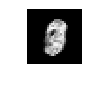

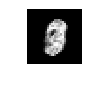

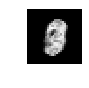

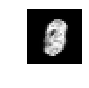

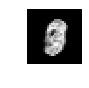

Execution time of method train: 5.499 seconds


In [6]:
def main():
    
    print("Using tensorflow {} for generating the variational autoencoder".format(tf.__version__))
    tf.reset_default_graph()
    trainer = AutoencoderTrainer(batch_size=64, latent_variables=49, iterations=10)
    trainer.train()
    
main()